In [1]:
import scipy.io
data = scipy.io.loadmat('data.mat')

import numpy as np
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Bias5', 'Bias_avg', 'DR_event_idx', 'K', 'MAPE5', 'MAPE_avg', 'NARE5', 'NARE_avg', 'customer', 'days', 'event_period', 'flag', 'i', 'test5'])


In [2]:
data['customer'][0][0][1][0][0]
# [customer]表示数据集的名称
# 第二个[]表示custmoer底下的内容，由于只有一份，故为0
# 第三个[]表示选取的行数,即为选取哪个用户
# 第四个[0]内容为选取用户的id，[1]表示用户数据
# 第五个[]表示选取结构体的行数,即为单个用户的表示的小时数
# 第六个[]表示列数，即为天数(171)

0.213

In [23]:
# 制作单个用户的数据集，以id:1002用户为例
dataset_1002 = []
id = 1002   # 用户id
for i in range(4104):
    dataset_1002.append(0)
# for i in range(171):
#     for j in range(24):
#         dataset_1002.append(data['customer'][0][id-1002][1][j][i])
for user in range(3637):
    for i in range(171):
        for j in range(24):
            dataset_1002[24*i+j] += data['customer'][0][user][1][j][i]
# for i in range(171):
#     for j in range(24):
#         dataset_1002[24*i+j] = math.sqrt(math.sqrt(dataset_1002[24*i+j]))
dataset_1002 = np.array(dataset_1002, dtype=np.float32)
print(dataset_1002.shape)

(4104,)


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

# scaler = MinMaxScaler(feature_range=(0,1))
# dataset_1002 = scaler.fit_transform(dataset_1002)
sns.set_style("darkgrid")
plt.figure(figsize=(280,105))
plt.plot(dataset_1002,linewidth =5, label="consumption")
plt.legend(loc="upper right", fontsize = 300)
plt.xlabel("time/(hour)", fontsize=300)
plt.ylabel("consumption/(kw)", fontsize = 300)
fig = plt.gcf()
plt.show()
fig.savefig("total")

In [5]:
from sklearn.preprocessing import OneHotEncoder
# 添加one-hot-encoder数据，用以拓展时间尺度上的数据特征
list_time = []
for day in range(7):
    for hour in range(24):
        list_time.append([hour,day])
print(list_time)
encoder = OneHotEncoder()
list_time = encoder.fit_transform(list_time).toarray()

[[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0], [10, 0], [11, 0], [12, 0], [13, 0], [14, 0], [15, 0], [16, 0], [17, 0], [18, 0], [19, 0], [20, 0], [21, 0], [22, 0], [23, 0], [0, 1], [1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1], [9, 1], [10, 1], [11, 1], [12, 1], [13, 1], [14, 1], [15, 1], [16, 1], [17, 1], [18, 1], [19, 1], [20, 1], [21, 1], [22, 1], [23, 1], [0, 2], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2], [8, 2], [9, 2], [10, 2], [11, 2], [12, 2], [13, 2], [14, 2], [15, 2], [16, 2], [17, 2], [18, 2], [19, 2], [20, 2], [21, 2], [22, 2], [23, 2], [0, 3], [1, 3], [2, 3], [3, 3], [4, 3], [5, 3], [6, 3], [7, 3], [8, 3], [9, 3], [10, 3], [11, 3], [12, 3], [13, 3], [14, 3], [15, 3], [16, 3], [17, 3], [18, 3], [19, 3], [20, 3], [21, 3], [22, 3], [23, 3], [0, 4], [1, 4], [2, 4], [3, 4], [4, 4], [5, 4], [6, 4], [7, 4], [8, 4], [9, 4], [10, 4], [11, 4], [12, 4], [13, 4], [14, 4], [15, 4], [16, 4], [17, 4], [18, 4], [19, 4], [20, 

In [6]:

# 进行数据集的划分，添加了负荷平均数
def split_data(stock, lookback, list_time = list_time):

    data = []
    for index in range(len(stock)-lookback):
        data.append(stock[index:index + lookback-24])
        for i in range(lookback-24):
            data[index].extend(list(list_time[(index + i)%(7*24)]))
        data[index].extend(stock[index+lookback-24:index+lookback])
    data = np.array(data, dtype=np.float32)
    # data = scale(data, with_mean=False, with_std=False)
    print(data.shape)
    
    test_set_size = int(np.round(0.3 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = np.array(data[:train_set_size,:-24], dtype=np.float32)
    # x_train = np.delete(x_train, [14,15], 1)
    y_train = np.array(data[:train_set_size, -1], dtype=np.float32)
    
    x_test = np.array(data[train_set_size:,:-24], dtype=np.float32)
    # x_test = np.delete(x_test, [14,15], 1)
    y_test = np.array(data[train_set_size:,-1], dtype=np.float32)
    return x_train, y_train, x_test, y_test

In [7]:
# 选取前十四天同一时刻的负载数值，故为 24 * 16 (第十五天预测第十六天)
x_train, y_train, x_test, y_test = split_data(dataset_1002, lookback=24*3)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(4032, 1560)
(2822, 1536)
(2822,)
(1210, 1536)
(1210,)


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
# from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data


#将数据集转化为张量 并处理为PyTorch网络使用的数据
train_xt=torch.from_numpy(x_train.astype(np.float32))
train_yt=torch.from_numpy(y_train.astype(np.float32))
test_xt=torch.from_numpy(x_test.astype(np.float32))
test_yt=torch.from_numpy(y_test.astype(np.float32))
#将数据处理为数据加载器
train_data=Data.TensorDataset(train_xt,train_yt)
test_data=Data.TensorDataset(test_xt,test_yt)
train_loader=Data.DataLoader(dataset=train_data,batch_size=5,shuffle=True,num_workers=0)

In [14]:
#搭建MLP回归模型
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        #定义第一个隐藏层
        self.hidden1=nn.Linear(in_features=1536,out_features=100,bias=True)#8*100 8个属性特征
        # #定义第二个隐藏层
        # self.hidden2=nn.Linear(100,100)#100*100
        # #定义第三个隐藏层
        # self.hidden3=nn.Linear(100,50)#100*50
        #回归预测层
        self.predict=nn.Linear(100,1)#50*1  预测只有一个 房价
    def forward(self,x):
        sigmoid = nn.Sigmoid()
        x=sigmoid(self.hidden1(x))
        # x=F.relu(self.hidden2(x))
        # x=F.relu(self.hidden3(x))
        output=self.predict(x)
        return output[:,0]
mlpreg=MLPregression()
print(mlpreg)

MLPregression(
  (hidden1): Linear(in_features=1536, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
)


Epoch: 0 Loss: 0.022354035473571073
Epoch: 1 Loss: 0.019463947501151446
Epoch: 2 Loss: 0.018370625561333807
Epoch: 3 Loss: 0.01808890018376263
Epoch: 4 Loss: 0.018009634035300204
Epoch: 5 Loss: 0.017761668057567397
Epoch: 6 Loss: 0.018001126784158536
Epoch: 7 Loss: 0.017894758279718124
Epoch: 8 Loss: 0.017824581764880332
Epoch: 9 Loss: 0.01750509670508729
Epoch: 10 Loss: 0.017676771427074866
Epoch: 11 Loss: 0.017640024971250414
Epoch: 12 Loss: 0.017726417388690068
Epoch: 13 Loss: 0.01768878090705366
Epoch: 14 Loss: 0.0175343673263374
Epoch: 15 Loss: 0.017304809240829003
Epoch: 16 Loss: 0.01773629931830451
Epoch: 17 Loss: 0.017454266378808952
Epoch: 18 Loss: 0.017209136749149208
Epoch: 19 Loss: 0.017380857054222276
Epoch: 20 Loss: 0.01754829186575209
Epoch: 21 Loss: 0.017326498814919714
Epoch: 22 Loss: 0.017421157498357535
Epoch: 23 Loss: 0.017532173755016544
Epoch: 24 Loss: 0.017289109038605747
Epoch: 25 Loss: 0.017224089053167725
Epoch: 26 Loss: 0.01726383932708034
Epoch: 27 Loss: 0.0

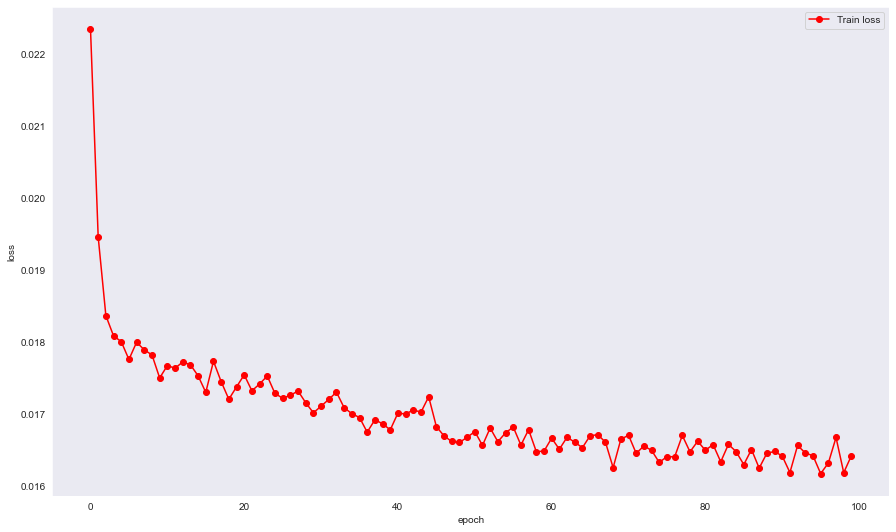

In [15]:
#定义优化器
optimizer=torch.optim.SGD(mlpreg.parameters(),lr=0.01)
loss_func=nn.MSELoss()
train_loss_all=[]
for epoch in range(100):
    train_loss=0
    train_num=0
    for step,(b_x,b_y) in enumerate(train_loader):
        output=mlpreg(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*b_x.size(0)
        train_num+=b_x.size(0)
    print("Epoch:",epoch,"Loss:",train_loss/train_num)
    train_loss_all.append(train_loss/train_num)
plt.figure(figsize=(15,9))
plt.plot(train_loss_all,"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

1210
RMSE is tensor(0.6102)
NRMSE is 0.6630461600821075


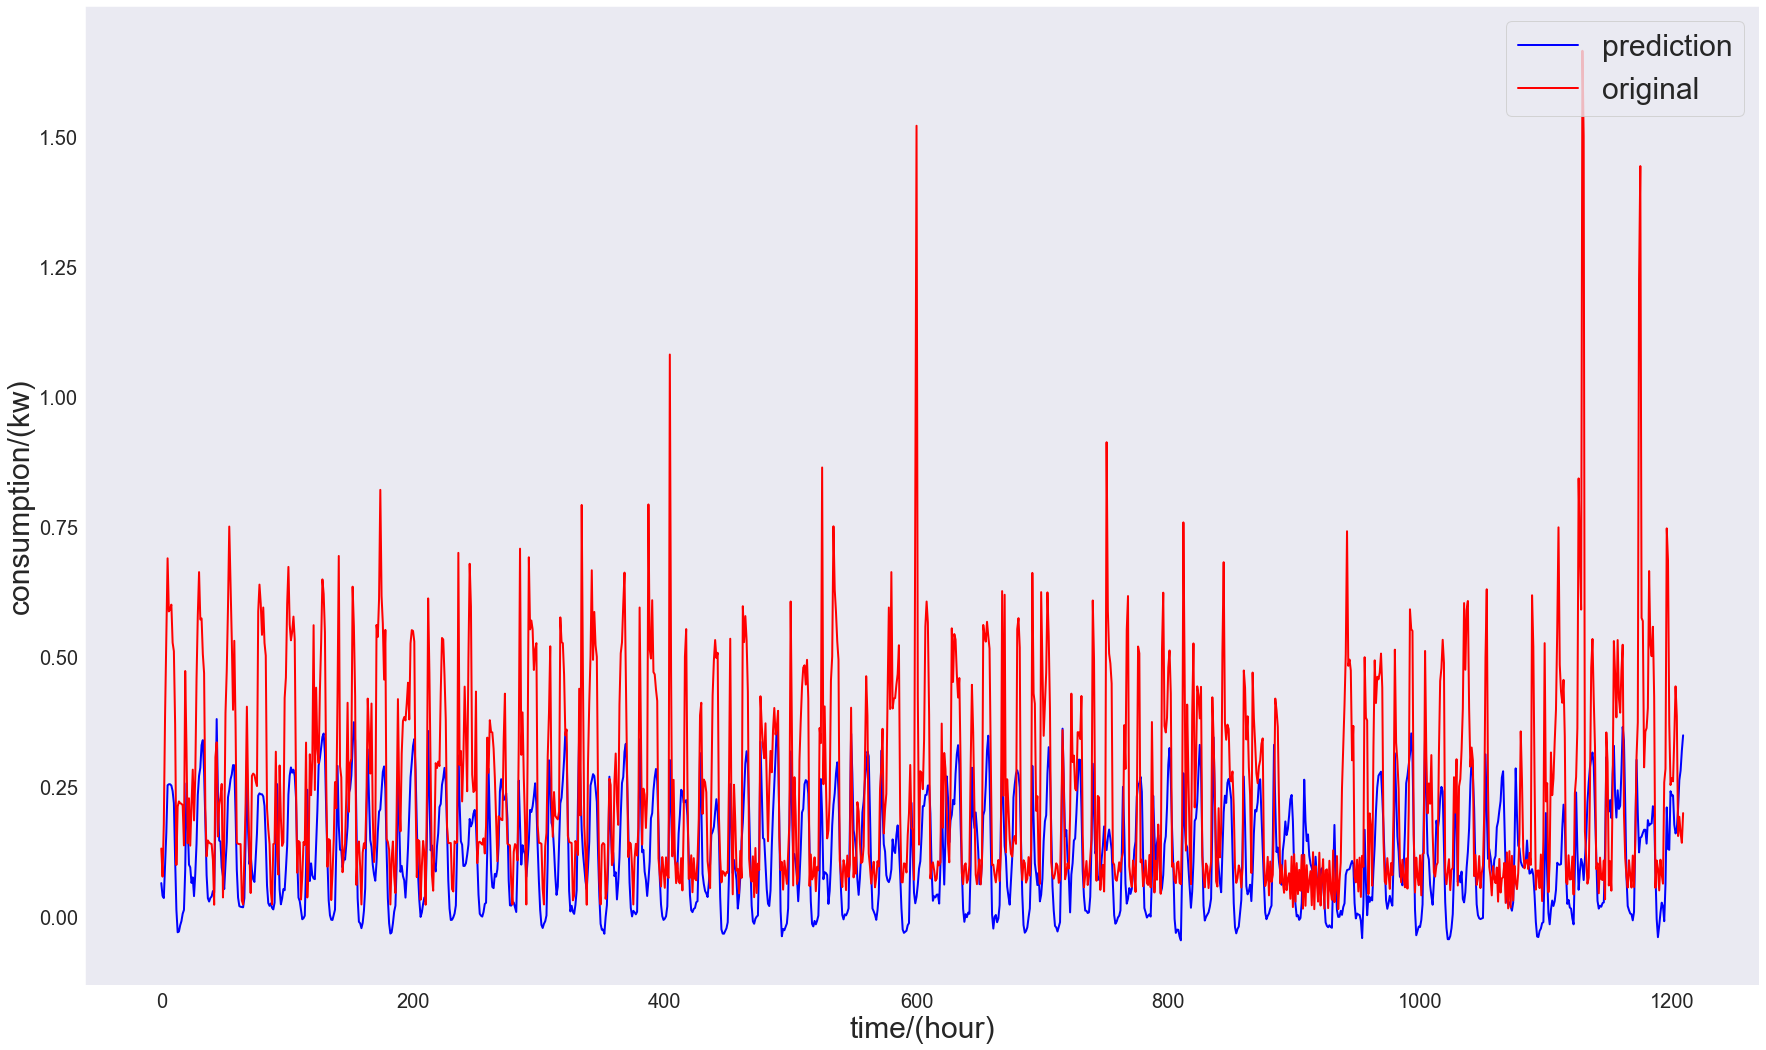

In [20]:
#预测
import math

pre_y=mlpreg(test_xt)
pre_y=pre_y.data.numpy()
test_yt = test_yt
print(len(pre_y))
# mae=mean_absolute_error(y_test,pre_y)
MAE,S1,RMSE,S2 = 0,0,0,0
for index in range(len(pre_y)):
    MAE += abs(pre_y[index]-test_yt[index])
    RMSE += (pre_y[index]-test_yt[index])**2
    S1 += abs(test_yt[index])
    S2 += test_yt[index]**2
    
NMAE = MAE/S1
NRMSE = math.sqrt(RMSE/S2)
print("RMSE is", NMAE)
print("NRMSE is", NRMSE)

# index=np.argsort(y_test)
sns.set_style("darkgrid")
plt.figure(figsize=(30,18))
plt.rcParams.update({"font.size":20})
# x=plt.title("aggregate_household_forecast",fontsize=40)
plt.plot(np.arange(1210), pre_y, c="b", label="prediction",linestyle="-",linewidth=2, marker='')
plt.plot(np.arange(1210), test_yt, c="r", label="original",linestyle="-",linewidth=2,marker="")
plt.legend(loc="upper right",fontsize=30)
# plt.plot(np.arange(len(y_test)),y_test[index],"r",label="original y")
# plt.scatter(np.arange(len(pre_y)),pre_y[index],s=3,c="b",label="prediction")
# plt.legend(loc="upper left")
plt.grid()
plt.xlabel("time/(hour)", fontsize=30)
plt.ylabel("consumption/(kw)", fontsize = 30)
fig = plt.gcf()
plt.show()
fig.savefig("1.jpg")
